<a href="https://colab.research.google.com/github/AshikSathiya/Prediction-of-Product-Sales/blob/main/Project_1_Revisited_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import pandas as change max columns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)

In [3]:
fpath = '/content/drive/MyDrive/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv'
df = pd.read_csv(fpath)
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


#Cleaning Process

##Drop Duplicates

In [4]:
# Duplicate Filter

duplicated_rows = df.duplicated()
duplicated_rows

# Calculate the sum of the duplicated_rows filter
duplicated_rows.sum()

0

There are no duplicates

##Inconsitencies

In [5]:
object_cols = df.select_dtypes('object').columns


In [6]:
# Check the nunique for just the object cols
object_nunique = df[object_cols].nunique()
object_nunique

Item_Identifier         1559
Item_Fat_Content           5
Item_Type                 16
Outlet_Identifier         10
Outlet_Size                3
Outlet_Location_Type       3
Outlet_Type                4
dtype: int64

It appears as though Item_Fat_Content, Outlet_Size, Outlet_Location_Type, and Outlet_Type have a small amount of values, we will look more into these columns

In [7]:
# Drop the columns listed above
df.drop(["Item_Identifier", "Item_Type", "Outlet_Identifier"], axis=1, inplace=True)
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,182.0950,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


In [8]:
# Remake the list of string columns (after dropping previous cols)
# loop through the list of string columns and print the value counts for the column


string_columns = df.select_dtypes(include='object').columns

for col in string_columns:
    value_counts = df[col].value_counts()
    print(value_counts)
    print()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64



Inconsitent values are present in the Item_Fat_Content

In [9]:
# Check for inconsistencies by inspecting the value_counts for Item_Fat_Content
Item_Fat_Content_counts = df['Item_Fat_Content'].value_counts()
print(Item_Fat_Content_counts)

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64



Rather than having 5 values, we should only have 2 (Low Fat and Regular)

In [10]:
# Standardize the values in the Central column
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({"LF":"Low Fat"})
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({"low fat":"Low Fat"})
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({"reg":"Regular"})


df['Item_Fat_Content'].value_counts()
# Check the value counts again to confirm
Item_Fat_Content_counts = df['Item_Fat_Content'].value_counts()
print(Item_Fat_Content_counts)

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64


##Split Data

In [11]:
y = df['Item_Outlet_Sales']
X = df.drop('Item_Outlet_Sales', axis = 1)

display(y)

display(X)

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,9.300,Low Fat,0.016047,249.8092,1999,Medium,Tier 1,Supermarket Type1
1,5.920,Regular,0.019278,48.2692,2009,Medium,Tier 3,Supermarket Type2
2,17.500,Low Fat,0.016760,141.6180,1999,Medium,Tier 1,Supermarket Type1
3,19.200,Regular,0.000000,182.0950,1998,NaN,Tier 3,Grocery Store
4,8.930,Low Fat,0.000000,53.8614,1987,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...,...
8518,6.865,Low Fat,0.056783,214.5218,1987,High,Tier 3,Supermarket Type1
8519,8.380,Regular,0.046982,108.1570,2002,NaN,Tier 2,Supermarket Type1
8520,10.600,Low Fat,0.035186,85.1224,2004,Small,Tier 2,Supermarket Type1
8521,7.210,Regular,0.145221,103.1332,2009,Medium,Tier 3,Supermarket Type2


In [12]:
# Train test split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
X_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 4776 to 7270
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                5285 non-null   float64
 1   Item_Fat_Content           6392 non-null   object 
 2   Item_Visibility            6392 non-null   float64
 3   Item_MRP                   6392 non-null   float64
 4   Outlet_Establishment_Year  6392 non-null   int64  
 5   Outlet_Size                4580 non-null   object 
 6   Outlet_Location_Type       6392 non-null   object 
 7   Outlet_Type                6392 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 449.4+ KB
<class 'pandas.core.series.Series'>
Int64Index: 6392 entries, 4776 to 7270
Series name: Item_Outlet_Sales
Non-Null Count  Dtype  
--------------  -----  
6392 non-null   float64
dtypes: float64(1)
memory usage: 99.9 KB


##Create a preprocessing object to prepare the dataset for Machine Learning

It appears that Outlet Size snd Outlet Location Type are our ordinal values

#Column Selectors

In [13]:
## make categorical selector and verify it works
cat_sel = make_column_selector(dtype_include='object')
cat_sel(X_train)

['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

In [14]:
## make numeric selector and verify it works
num_sel = make_column_selector(dtype_include='number')
num_sel(X_train)

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

## Pipelines

In [15]:
## make pipelines for categorical vs numeric data

#Include drop first for categorical
cat_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='MISSING'),
                         OneHotEncoder(drop='first', sparse=False))


num_pipe = make_pipeline(SimpleImputer(strategy='mean'))





In [16]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x796f364a3940>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x796f364a2650>)],
                  verbose_feature_names_out=False)

In [17]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_Regular',
       'Outlet_Size_MISSING', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'], dtype=object)

#Remake your X_train and X_test as DataFrames

In [18]:
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,16.35,0.029565,256.4646,2009.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
7510,15.25,0.000000,179.7660,2009.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
5828,12.35,0.158716,157.2946,1999.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,14.30,0.026300,79.4302,1987.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2957,7.93,0.071136,42.7086,1997.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7031,14.50,0.041313,42.0454,1999.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
## confirm the first 3 rows index in y_test matches X_test_df
y_test.head(3)

7503    1743.0644
2957     356.8688
7031     377.5086
Name: Item_Outlet_Sales, dtype: float64

In [21]:
for col in cat_sel(X):
    print(f"For {col}:\n{X[col].unique()}\n")

For Item_Fat_Content:
['Low Fat' 'Regular']

For Outlet_Size:
['Medium' nan 'High' 'Small']

For Outlet_Location_Type:
['Tier 1' 'Tier 3' 'Tier 2']

For Outlet_Type:
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']



#Functions

In [22]:
def evaluate_regression(model, X_train,y_train, X_test, y_test):
    """Evaluates a scikit-learn-compatible regression model using r-squared and RMSE

    Args:
        model (Regressor): Regression Model with a .predict method
        X_train (DataFrame): Training Features
        y_train (Series): Training Target
        X_test (DataFrame): Test Features
        y_test (Series): Test Target
    """

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train,
                                            squared=False)

    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")


    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test,
                                            squared=False)

    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

#LinearRegression


In [23]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.56	RMSE= 1140.10
Test Data:	R^2= 0.57	RMSE= 1089.53


In [24]:
coeffs = pd.Series(lin_reg.coef_, index=feature_names,
                        name='Coefficients')

In [25]:
## rank the coeffs and select the top_n
top_n=10
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n)
coeffs_plot = coeffs.loc[top_n_features.index].sort_values()
coeffs_plot

Outlet_Size_MISSING              -746.738624
Outlet_Size_Small                -611.391528
Outlet_Size_Medium               -554.527339
Item_Visibility                  -448.846052
Outlet_Location_Type_Tier 3      -248.809905
Outlet_Location_Type_Tier 2       -45.703339
Item_Fat_Content_Regular           64.115619
Outlet_Type_Supermarket Type2    1161.917267
Outlet_Type_Supermarket Type1    1547.303593
Outlet_Type_Supermarket Type3    3532.291811
Name: Coefficients, dtype: float64

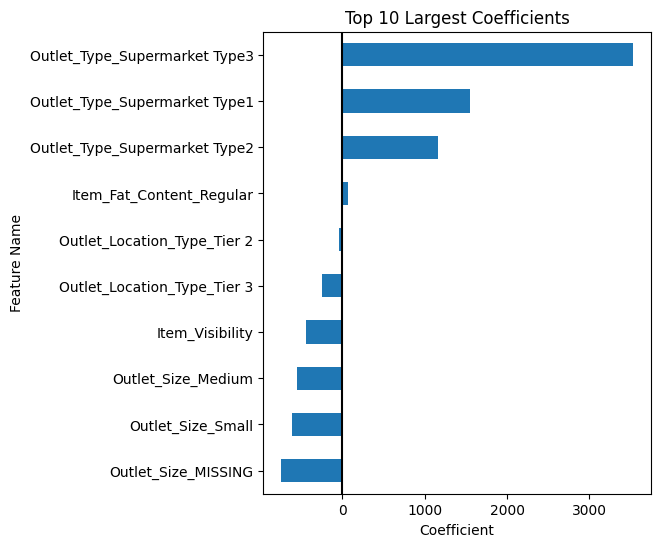

In [26]:
## sort features and keep top_n and set title
ax = coeffs_plot.sort_values().plot(kind='barh',figsize=(5,6))
ax.axvline(0,color='k');
ax.set(title = f"Top {top_n} Largest Coefficients",ylabel="Feature Name",
      xlabel='Coefficient');

In [27]:
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs.tail()

Outlet_Location_Type_Tier 3       -248.809905
Outlet_Type_Supermarket Type1     1547.303593
Outlet_Type_Supermarket Type2     1161.917267
Outlet_Type_Supermarket Type3     3532.291811
intercept                       -55869.811600
Name: Coefficients, dtype: float64

The retailer aims to improve sales performance for food items across their various stores. To achieve this, they seek to develop a sales prediction model that can provide valuable insights into the factors that significantly influence sales.

We found the three most impactful features. We are prediciting for the sales of the product in the particular store.

The three Outlet Type Supermarkets all had a very significant impact on Sales Production. Each of these SuperMarkets impact Sales Production positvely to varying degrees.

Outlet_Type_Supermarket Type3 increases item sales production by 3532.3 items.
Outlet_Type_Supermarket Type1 increases item sales production by 1547.3 items.
Outlet_Type_Supermarket Type2 increases item sales production by 1161.9 items.


#Tree Based Model

In [28]:
reg = RandomForestRegressor()
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 432.39
Test Data:	R^2= 0.55	RMSE= 1111.45


In [29]:
feature_importance = pd.Series(reg.feature_importances_, index=feature_names,
                        name='Feature Importances')
feature_importance.head()

Item_Weight                  0.071421
Item_Visibility              0.127797
Item_MRP                     0.470594
Outlet_Establishment_Year    0.050068
Item_Fat_Content_Regular     0.012826
Name: Feature Importances, dtype: float64

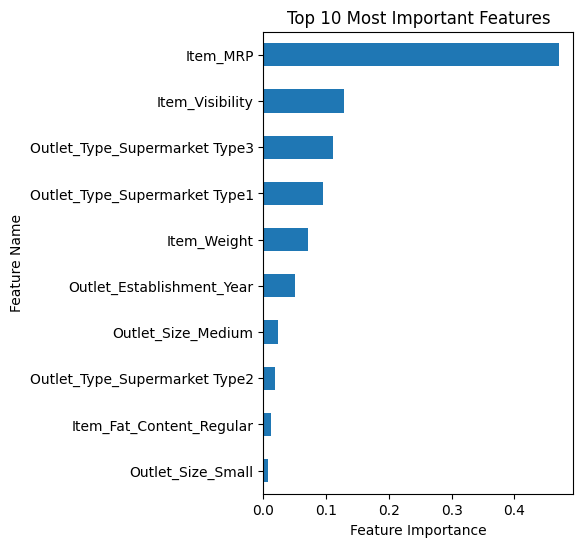

In [30]:
ax = feature_importance.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Feature Importance',
       title='Top 10 Most Important Features');

The 5 most important features are Item_MRP, Item_Visibility, Outlet_Type_Supermarket Type3, Outlet_Type_Supermarket Type1, Item_Weight

#Serialization


Once you've finished updating and explaining your models, you must save the following key: value pairs as a dictionary in a joblib file named "best-models.joblib":

"preprocessor": your preprocessing  column transformer

"X_train": your training features.

"X_test": your test features.

"y_train": your training target.

"y_test": your test target.

"LinearRegression": your best linear regression

Your tree-based model's class name: your best tree-based model.

e.g. "RandomForestRegressor"/"DecisionTreeRegressor"
Save your joblib file inside your repository. (You will work with these models again in the next core assignment.)


In [31]:
## saving variables for next lesson/notebook
import joblib
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'LinearRegression':lin_reg,
         'RandomForest':reg}
joblib.dump(export, 'sales_prediction_models.joblib')

['sales_prediction_models.joblib']